In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn import tree

C:\Users\35843\AppData\Local\Temp\ipykernel_6048\1807696676.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


指标分类

In [2]:
metrics_unprocessed=["active_dates_and_times",
                     "issue_response_time",
                     "issue_resolution_duration",
                     "issue_age",
                     "change_request_response_time",
                     "change_request_resolution_duration",
                     "change_request_age"
                     ]

metrics_processed=["openrank",
                   "technical_fork",
                   "new_contributors",
                   "inactive_contributors",
                   "bus_factor",
                   "issues_new",
                   "issues_closed",
                   "code_change_lines_add",
                   "code_change_lines_remove",
                   "code_change_lines_sum",
                   "change_requests",
                   "change_requests_accepted",
                   "change_requests_reviews"
                  ]

导入数据

In [3]:
data_path="../Data/top_300_metrics/"

def is_CHAOSS(met):
    return (met in metrics_unprocessed) or (met in metrics_processed)

def get_table(prj_path):
    time = []
    act_dnt = []

    with open(os.path.join(prj_path, metrics_unprocessed[0] + ".json")) as f:
        data=json.load(f)
        for key, value in data.items():
            time.append(key)
            act_dnt.append(np.average(np.array(value)))

    metric_table = pd.DataFrame({"time":time, "active_dates_and_times":act_dnt})
    for f in os.listdir(prj_path):
        f_path = os.path.join(prj_path, f)
        metric = f[:-5]

        if (metric == metrics_unprocessed[0]) or (not is_CHAOSS(metric)):
            continue

        with open(f_path) as file:
            data = json.load(file)

            if metric in metrics_unprocessed:
                data = data['avg']
                
            if "2021-10-raw" in data:
                data.pop("2021-10-raw")
            file.close()

        metric_table[metric] = metric_table['time'].map(data).fillna(0)

    return metric_table



met_table = []

for organization in tqdm(os.listdir(data_path)):
    org_path = os.path.join(data_path, organization)

    for project in os.listdir(org_path):
        prj_path = os.path.join(org_path, project)
        prj_met_table = get_table(prj_path)
        met_table.append(prj_met_table)
        

        


100%|██████████| 235/235 [01:27<00:00,  2.69it/s]


数据处理

In [4]:
data = pd.concat(met_table).fillna(0)
data = data.reset_index(drop=True)

data['time'] = pd.to_datetime(data['time'], format="%Y-%m")
data["Time"] = (data["time"].dt.year - data["time"].dt.year.min()) * 12 + data["time"].dt.month
Data = data.drop(columns=['time'])

划分训练集验证集

In [5]:
test_data = data[data['time']>="2023-01"]
train_data = data[data['time']<"2023-01"]

X_train = train_data.drop(columns=["openrank","time"])
y_train = train_data["openrank"]

X_test = test_data.drop(columns=["openrank","time"])
y_test = test_data["openrank"]

print("Data Shape:{}, Train data shape:{}, Test data Shape:{}".format(Data.shape,X_train.shape,X_test.shape))

Data Shape:(21572, 21), Train data shape:(20678, 20), Test data Shape:(894, 20)


查看特征

In [6]:
Data.columns

Index(['active_dates_and_times', 'bus_factor', 'change_requests',
       'change_requests_accepted', 'change_requests_reviews',
       'change_request_age', 'change_request_resolution_duration',
       'change_request_response_time', 'code_change_lines_add',
       'code_change_lines_remove', 'code_change_lines_sum',
       'inactive_contributors', 'issues_closed', 'issues_new', 'issue_age',
       'issue_resolution_duration', 'issue_response_time', 'new_contributors',
       'openrank', 'technical_fork', 'Time'],
      dtype='object')

In [12]:
Data['Time']

0         1
1         2
2         3
3         4
4         5
         ..
21567    95
21568    96
21569    97
21570    98
21571    99
Name: Time, Length: 21572, dtype: int32

In [8]:
Data['openrank'].describe()

count    21572.000000
mean       251.546959
std        258.252390
min          0.000000
25%        106.840000
50%        194.940000
75%        301.190000
max       4829.380000
Name: openrank, dtype: float64

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap(X):
    f,ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(X.corr(), annot=True, linecolor='white',linewidths=0.1,cmap="RdBu", fmt= '.1f',ax=ax)

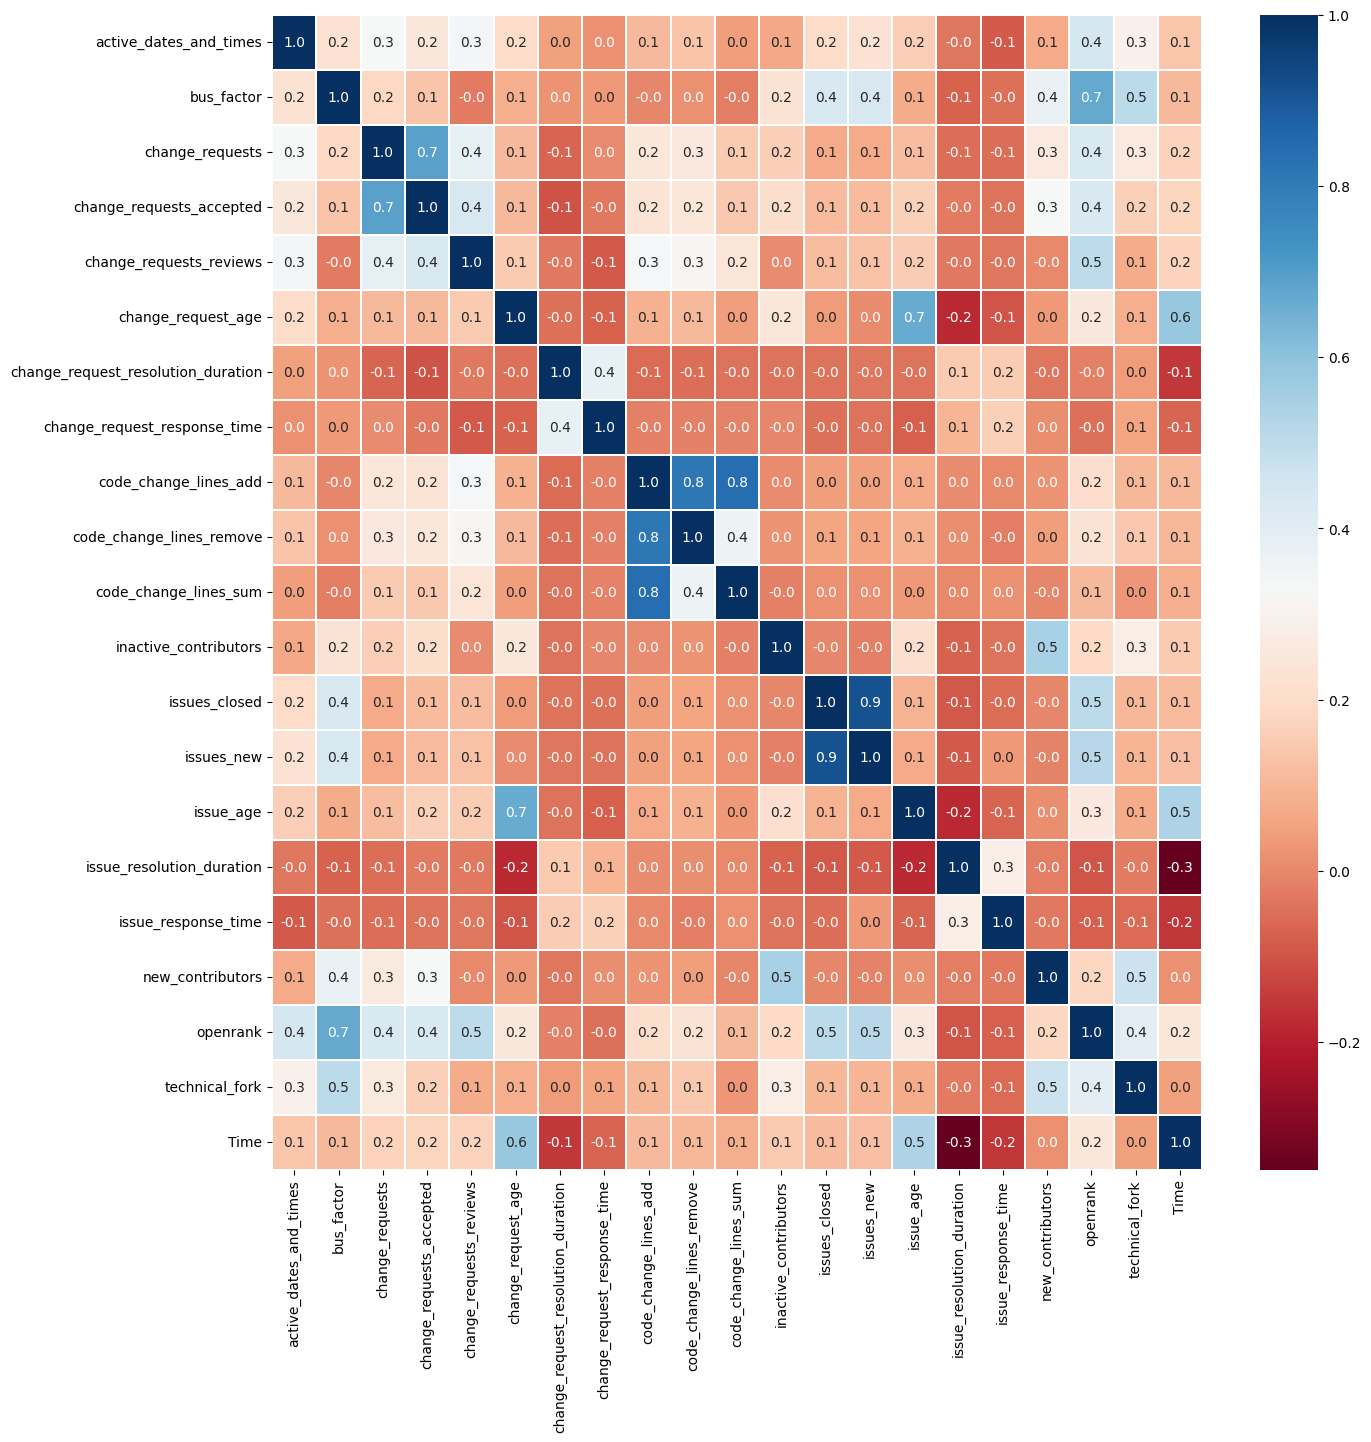

In [10]:
heatmap(Data)